* In this notebook we are going to the simple linear regression model on Cuda (GPU)

In [56]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt # type: ignore

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.1.2+cu118
Numpy version: 1.24.1


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# let's prepare data
n_samples = 500

x = torch.rand((n_samples, 1), dtype=torch.float) * 10
x.shape

torch.Size([500, 1])

In [5]:
# let's define some noise
noise = np.random.normal(loc=1.2, scale=2.1, size=(n_samples, 1))
noise.shape

(500, 1)

In [6]:
y = 5.5 - (2.6*x) + noise
y = y.float()
y.shape

torch.Size([500, 1])

In [7]:
x.dtype, y.dtype

(torch.float32, torch.float32)

In [8]:
def plot_scatter(x, y, y_pred=None, title='Scatter Plot', xlabel='x', ylabel='y', 
                    figsize=(6, 4), marker_color='blue', marker_edgecolor='black', marker_size=100, alpha=0.75):
    
    plt.figure(figsize=figsize)  # Set figure size
    
    # Plot actual values
    plt.scatter(x, y, color=marker_color, edgecolor=marker_edgecolor, s=marker_size, alpha=alpha, label='Actual')
    
    # Plot predicted values if y_pred is provided
    if y_pred is not None:
        plt.scatter(x, y_pred, color='red', edgecolor='black', s=marker_size, alpha=0.75, label='Predicted')

    # Add labels and title
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Add legend if predictions are plotted
    if y_pred is not None:
        plt.legend()

    # Display the plot
    plt.show()

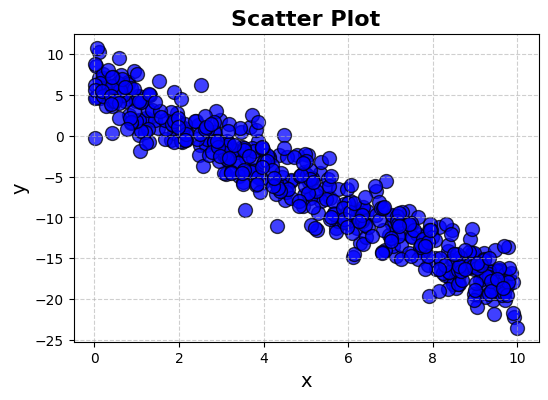

In [9]:
plot_scatter(x, y)

In [10]:
# let's perform train-test split
train_split = int(0.75 * x.shape[0])

X_train, y_train = x[:train_split, :], y[:train_split, :]
X_test, y_test = x[train_split:, :], y[train_split:, :]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([375, 1]),
 torch.Size([375, 1]),
 torch.Size([125, 1]),
 torch.Size([125, 1]))

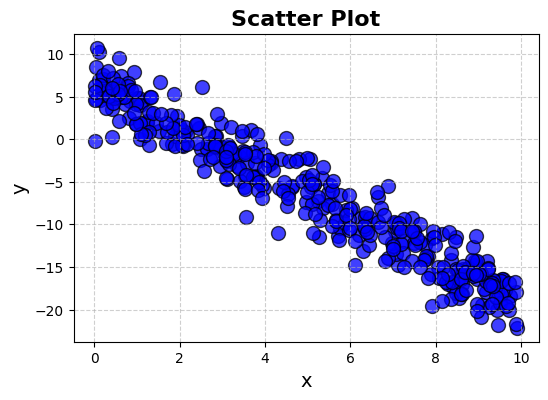

In [11]:
plot_scatter(X_train, y_train)

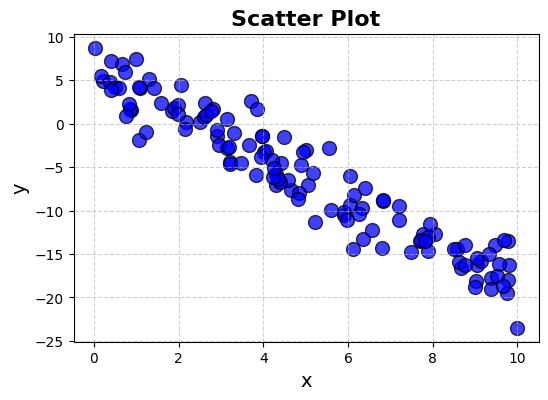

In [12]:
plot_scatter(X_test, y_test)

In [13]:

class LinearRegressionModel(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.weights = nn.Parameter(torch.randn(1, 
                                                requires_grad=True, 
                                                dtype=torch.float)
                                    )
        
        self.bias = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float)
                                    )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

In [14]:
linear_model = LinearRegressionModel()
list(linear_model.parameters())

[Parameter containing:
 tensor([1.0622], requires_grad=True),
 Parameter containing:
 tensor([-0.3232], requires_grad=True)]

In [17]:
next(linear_model.parameters()).device

device(type='cpu')

In [18]:
# let's put the model in GPU
linear_model.to(device)

LinearRegressionModel()

In [20]:
# now the model is in cuda
next(linear_model.parameters()).device

device(type='cuda', index=0)

In [21]:
# define the loss fn
loss_fn = nn.MSELoss()

# setup an optimizer
optimizer = torch.optim.SGD(params=linear_model.parameters(),
                            lr=0.01)

In [22]:
# now, let's all the data in GPU
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [24]:
X_train.device, y_test.device

(device(type='cuda', index=0), device(type='cuda', index=0))

* now, everything is in cuda let's train the model

In [27]:
# Set the number of epochs (how many times the model will pass over the training data)
epochs = 500

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    linear_model.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = linear_model(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    linear_model.eval()

    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = linear_model(X_test)

        # 2. Caculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

        # Print out what's happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss}\n")
        
        # Save the loss values (move them to CPU before converting to NumPy)
        train_loss_values.append(loss.detach().cpu().numpy())
        test_loss_values.append(test_loss.detach().cpu().numpy())

Epoch: 0 | MSE Train Loss: 40.694454193115234 | MSE Test Loss: 17.93581199645996

Epoch: 10 | MSE Train Loss: 16.706636428833008 | MSE Test Loss: 15.592813491821289

Epoch: 20 | MSE Train Loss: 15.463479995727539 | MSE Test Loss: 14.4541015625

Epoch: 30 | MSE Train Loss: 14.347085952758789 | MSE Test Loss: 13.434006690979004

Epoch: 40 | MSE Train Loss: 13.344531059265137 | MSE Test Loss: 12.520312309265137

Epoch: 50 | MSE Train Loss: 12.444207191467285 | MSE Test Loss: 11.702043533325195

Epoch: 60 | MSE Train Loss: 11.635685920715332 | MSE Test Loss: 10.969350814819336

Epoch: 70 | MSE Train Loss: 10.909610748291016 | MSE Test Loss: 10.313396453857422

Epoch: 80 | MSE Train Loss: 10.25757122039795 | MSE Test Loss: 9.726249694824219

Epoch: 90 | MSE Train Loss: 9.67202091217041 | MSE Test Loss: 9.200794219970703

Epoch: 100 | MSE Train Loss: 9.1461763381958 | MSE Test Loss: 8.730642318725586

Epoch: 110 | MSE Train Loss: 8.673954010009766 | MSE Test Loss: 8.310067176818848

Epoch: 1

In [28]:
linear_model.state_dict()

OrderedDict([('weights', tensor([-2.4876], device='cuda:0')),
             ('bias', tensor([5.8942], device='cuda:0'))])

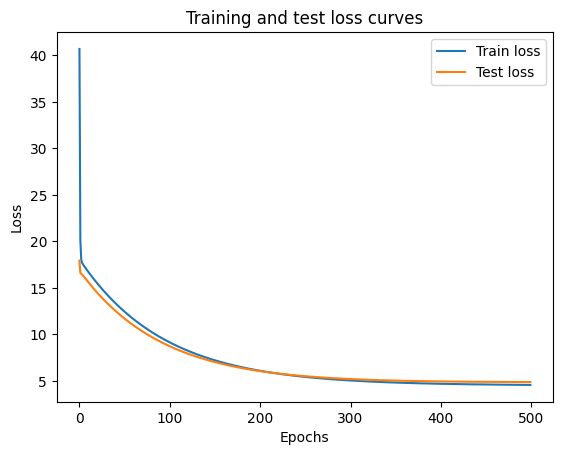

In [29]:
# Plot the loss curves
plt.plot(range(epochs), train_loss_values, label="Train loss")
plt.plot(range(epochs), test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [30]:
# make prediction with model

with torch.inference_mode():
    y_pred = linear_model(X_test)

y_pred.shape

torch.Size([125, 1])

In [31]:
error = (y_pred - y_test)
squared_error = torch.sum(error**2, dim=0)
mse = squared_error / y_test.shape[0]
mse

tensor([4.8871], device='cuda:0')

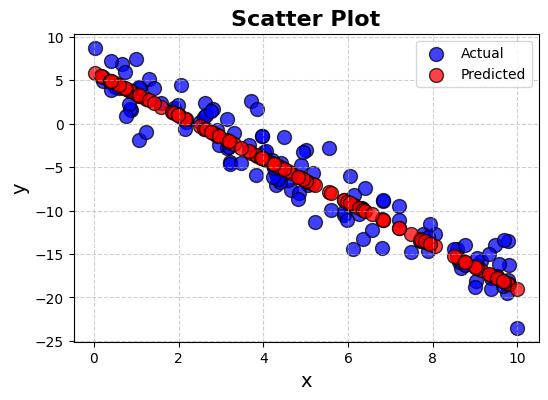

In [33]:
plot_scatter(X_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), y_pred=y_pred.detach().cpu().numpy())

In [34]:
((y_pred - y_test) ** 2).mean()

tensor(4.8871, device='cuda:0')

* Let's train the model using `autograd`

In [35]:
linear_model1 = LinearRegressionModel()

In [37]:
linear_model1.to(device)

LinearRegressionModel()

In [38]:
next(linear_model1.parameters()).device

device(type='cuda', index=0)

In [39]:

def loss_fn(y_pred: torch.Tensor, y_true: torch.Tensor):
    return ((y_pred - y_true) ** 2).mean()

In [40]:
# set the learning rate
lr = 0.01
epochs = 500

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []



for epoch in range(epochs):
    
    # put the model in training mode
    linear_model1.train()
    
    # forward pass: compute the model prediction
    y_pred = linear_model1.forward(X_train)
    
    # compute the loss: MSE
    loss = loss_fn(y_pred=y_pred, y_true=y_train)
    
    # gradients calculation
    # use autograd to compute gradients of the loss with respect to weights and bias
    gradients = torch.autograd.grad(loss, [linear_model1.weights, linear_model1.bias], create_graph=True)
    
    # optimization step
    # Update the model's parameters manually using gradient descent
    with torch.no_grad():
        linear_model1.weights.data -= (lr * gradients[0])
        linear_model1.bias.data -= (lr * gradients[1])
    
    # put the model in evaluation mode
    linear_model1.eval()
    
    with torch.inference_mode():
        y_pred_test = linear_model1.forward(X_test)
        
        test_loss = loss_fn(y_pred=y_pred_test, y_true=y_test)
        
        # Print out what's happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss}\n")
        
        train_loss_values.append(loss.detach().cpu().numpy())
        test_loss_values.append(test_loss.detach().cpu().numpy())

Epoch: 0 | MSE Train Loss: 23.057540893554688 | MSE Test Loss: 20.373552322387695

Epoch: 10 | MSE Train Loss: 19.684648513793945 | MSE Test Loss: 18.330286026000977

Epoch: 20 | MSE Train Loss: 18.137826919555664 | MSE Test Loss: 16.90688133239746

Epoch: 30 | MSE Train Loss: 16.748733520507812 | MSE Test Loss: 15.631428718566895

Epoch: 40 | MSE Train Loss: 15.501283645629883 | MSE Test Loss: 14.488688468933105

Epoch: 50 | MSE Train Loss: 14.381036758422852 | MSE Test Loss: 13.464988708496094

Epoch: 60 | MSE Train Loss: 13.375018119812012 | MSE Test Loss: 12.548059463500977

Epoch: 70 | MSE Train Loss: 12.471586227416992 | MSE Test Loss: 11.72689151763916

Epoch: 80 | MSE Train Loss: 11.660273551940918 | MSE Test Loss: 10.991597175598145

Epoch: 90 | MSE Train Loss: 10.931690216064453 | MSE Test Loss: 10.333312034606934

Epoch: 100 | MSE Train Loss: 10.277400016784668 | MSE Test Loss: 9.744074821472168

Epoch: 110 | MSE Train Loss: 9.689826965332031 | MSE Test Loss: 9.2167444229125

In [41]:
linear_model1.state_dict()

OrderedDict([('weights', tensor([-2.4794], device='cuda:0')),
             ('bias', tensor([5.8390], device='cuda:0'))])

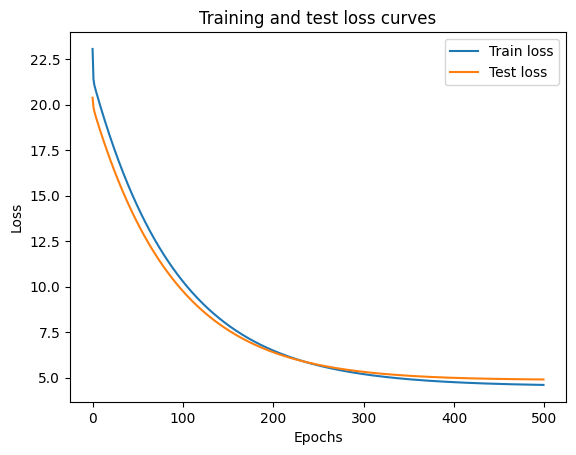

In [42]:
# Plot the loss curves
plt.plot(range(epochs), train_loss_values, label="Train loss")
plt.plot(range(epochs), test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [43]:
# saving a model in PyTorch
from pathlib import Path

In [44]:
# model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = "02_pytorch_workflow_model0.pth"

# create model save path
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

WindowsPath('models/02_pytorch_workflow_model0.pth')

In [45]:
# save the model state_dict()
print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(linear_model.state_dict(), 
            f=MODEL_SAVE_PATH)

saving model to: models\02_pytorch_workflow_model0.pth


In [46]:
loaded_model0 = LinearRegressionModel()
loaded_model0.state_dict()

OrderedDict([('weights', tensor([1.9151])), ('bias', tensor([0.6702]))])

In [47]:
loaded_model0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [50]:
loaded_model0.to(device)

LinearRegressionModel()

In [51]:
loaded_model0.state_dict()

OrderedDict([('weights', tensor([-2.4876], device='cuda:0')),
             ('bias', tensor([5.8942], device='cuda:0'))])

In [52]:
next(loaded_model0.parameters()).device

device(type='cuda', index=0)

In [53]:
loaded_model0.eval()

with torch.inference_mode():
    loaded_model_pred = loaded_model0(X_test)

In [55]:
((loaded_model_pred - y_test) ** 2).mean()

tensor(4.8871, device='cuda:0')